In [16]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from pathlib import Path
import os

In [13]:
dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
api_key=os.getenv("gptAPIKEY")
# print(api_key)

In [4]:
class Agent(TypedDict):
    message : Annotated[Sequence[BaseMessage],add_messages]

In [5]:
@tool
def add(a,b):
    "returns the sum of the 2 int type variables"
    return a+b


tools=[add]

In [6]:
llm= ChatOpenAI(model="z-ai/glm-4.5-air:free",api_key=api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools)

In [15]:
def model_call(state:Agent)->Agent:
    system_prompt= SystemMessage(content="You are an ai assistant answer my queries to the best of you ability")
    response=llm.invoke([system_prompt]+state["message"])
    return {"message":[response]}

def should_continue(state:Agent):
    messages=state['message']
    last_message=messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    
graph=StateGraph(Agent)
graph.add_node("our_agent",model_call)

toolnode=ToolNode(tools=tools)
graph.add_node("tools",toolnode) 

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue" : "tools",
        "end":END,
    },
)

graph.add_edge("tools",'our_agent')

app=graph.compile()

def print_stream(stream):
    for s in stream:
        message=s['message'][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

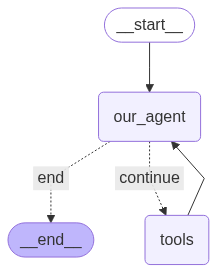

In [11]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
input={'message':[HumanMessage("Add 3 + 4")]}
print_stream(app.stream(input=input,stream_mode="values"))

================================ Human Message =================================

Add 3 + 4


RateLimitError: Error code: 429 - {'error': {'message': 'Provider returned error', 'code': 429, 'metadata': {'raw': 'z-ai/glm-4.5-air:free is temporarily rate-limited upstream. Please retry shortly, or add your own key to accumulate your rate limits: https://openrouter.ai/settings/integrations', 'provider_name': 'Z.AI'}}, 'user_id': 'user_30YjzqgsosEIruJUqMzNA8HMtby'}